# Cell Division 

## On a 2D mesh

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model

from tyssue.draw.plt_draw import sheet_view
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division
from tyssue.core.objects import get_opposite

/home/guillaume/miniconda3/envs/py36/lib/python3.6/site-packages/tyssue-0.2rc1-py3.6.egg/tyssue/dynamics/factory.py:55: UserWarning: This badly worded method is deprecated,
 use dimensionalize instead
  use dimensionalize instead''')
Reseting datasets values with new specs


Number of cells: 20
          edges: 116
          vertices: 54



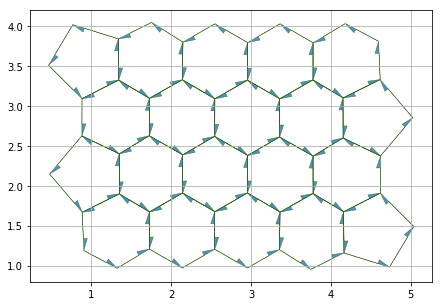

In [2]:
sheet = Sheet.planar_sheet_2d('division', 6, 6, 1, 1)
sheet.sanitize()
geom.update_all(sheet)

sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)

# ## Set up the model
nondim_specs = config.dynamics.quasistatic_plane_spec()
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

print("Number of cells: {}\n"
      "          edges: {}\n"
      "          vertices: {}\n".format(sheet.Nf, sheet.Ne, sheet.Nv))

# ## Minimize energy
res = solver.find_energy_min(sheet, geom, model)

# ## View the result
draw_specs = config.draw.sheet_spec()
draw_specs['vert']['visible'] = False
draw_specs['edge']['head_width'] = 0.1
fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

True


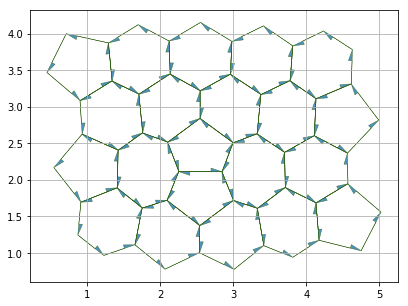

In [3]:
daughter = cell_division(sheet, 7, geom, angle=np.pi/2)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

## Division in a 3D single layer epithelium

In [4]:
from tyssue.io.hdf5 import save_datasets, load_datasets
# redefine cell_division from monolayer related topology module
from tyssue.topology.monolayer_topology import cell_division

from tyssue.core.monolayer import Monolayer
from tyssue.geometry.bulk_geometry import BulkGeometry
from tyssue.dynamics.bulk_model import BulkModel
from tyssue.draw.vispy_draw import vp_view


In [5]:
datasets = load_datasets('../examples/small_ellipsoid.hf5',
                         data_names=['vert', 'edge',
                                     'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)

monolayer.update_specs(config.dynamics.quasistatic_bulk_spec())
# ### Modifier for each segment of the stratum
modifiers = {
    'sagittal': {
        'edge': {
            'line_tension': 0.1},
        'face': {
            'contractility': 0.05}
    },
    'basal': {
        'edge': {
            'line_tension': 0.5},
        'face': {
            'contractility': 0.1}},
    }



def set_model(eptm, modifiers):
    for segment, spec in modifiers.items():
        for element, parameters in spec.items():
            idx = eptm.segment_index(segment, element)
            for param_name, param_value in parameters.items():
                eptm.datasets[element].loc[
                    idx, param_name] = param_value * eptm.specs[element][param_name]

set_model(monolayer, modifiers)

In [6]:
mother = 8
daughter = cell_division(monolayer, mother, 
                         orientation='vertical')

ValueError: An invalid epithelium was produced

In [7]:

rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors
draw_specs['face']['color'] = '#aaaaaaaa'

canvas, view = vp_view(monolayer, coords=['z', 'x', 'y'], **draw_specs)

fig, ax = plt.subplots()
ax.imshow(canvas.render())
fig.set_size_inches(12, 12)


RuntimeError: context could not be created

In [27]:
res = solver.find_energy_min(monolayer, BulkGeometry, BulkModel)

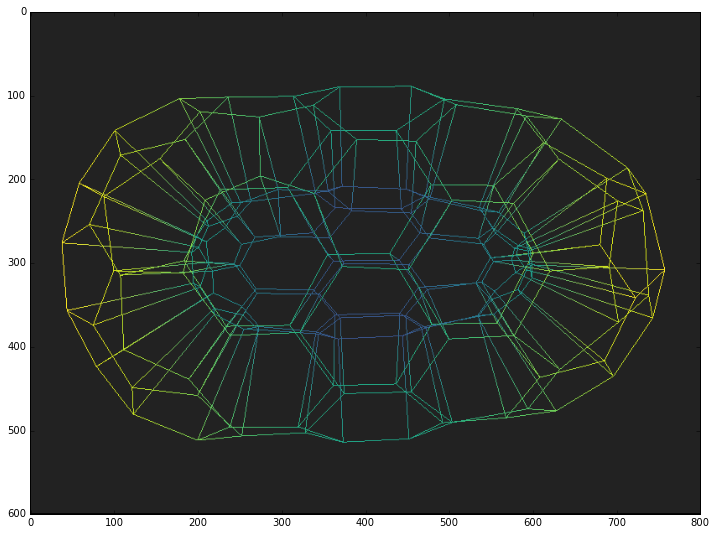

In [28]:
rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors
draw_specs['face']['color'] = '#aaaaaaaa'

canvas, view = vp_view(monolayer, coords=['z', 'x', 'y'], **draw_specs)

fig, ax = plt.subplots()
ax.imshow(canvas.render())
fig.set_size_inches(12, 12)